<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Particle Tracking</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM 480A5, Spring 2025
Instructor: Brian Munsky
Authors: Dr. Luis Aguilera, Dr. Zach Fox,  Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>

This notebook provides an implementation of a i) 2D random walk simulator and ii) a particle tracking pipeline. At the end of the tutorial, the student is expected to acquire the computational skills to implement the following list of objectives independently.

## Learning Objectives
Upon completion of this lesson, you will be able to:

1.   Simulate 2D random walks in python
2.   Describe the main steps needed for particle tracking (e.g., detection, linking).
3.   Implement python codes to detect particles within an image.
4.   Implement python codes to link particles between successive frames.
5.   Calculate mean square displacement and diffusion coefficients.
6.   Use modern scientific libraries in python  to segment and track single molecules in live cells.

In [73]:
# %pip install --upgrade  cellpose
# os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
from cellpose import plot, models
# Note -- your kernel may crash when running this cell. 
# If it does, just restart the kernel and run this cell again.

In [74]:
# Loading libraries
import matplotlib.pyplot as plt                    # Library used for plotting
from matplotlib import animation                   # Library to plot animations
import numpy as np                                 # library for array manipulation
import random                                      # Library to generate random numbers
from random import randrange                       # Library to generate random numbers
import math                                        # Library for math calculations
from scipy.spatial import KDTree                   # Module to link trajectories
import skimage                                     # Library for image manipulation
from skimage.util import random_noise              # Module to add random noise to the image
from skimage import measure                        # Module to find contours on images
import skimage                                     # Library for image manipulation
from skimage.io import imread                      # Module to read images
from IPython.display import HTML                   # To display a mp4 video
import ipywidgets as widgets                       # Library to plot widgets
from ipywidgets import interact, interactive, HBox, Layout, VBox #  importing modules and functions.
import urllib.request                              # importing library to download data
import pandas as pd

# ! pip install trackpy
import trackpy as tp # Library for particle tracking

# !pip install PyWavelets

# 1. Particle Simulator

![alt text](FigsA/Module_1_3/Slide3.png)

![alt text](FigsA/Module_1_3/Slide4.png)

## 1.A. Code for a 2-D random walk.

In [75]:
# Code for 2D random walk

def generate_gaussian_at_position(img_size, position, size_spot = 9, spot_sigma = 2):
  '''
  This function is intended to create a 2-D Gaussian matrix at a given position.
  Inputs:
    img_size: list of two int, with format [x_size, y_size]. Units are pixels.
    position: list of two int, with format [x_position, y_position]. Units are pixels.
    size_spot: int, size of the spot to generate. Units are pixels.
    spot_sigma: int, standard deviation of the Gaussian. Units are pixels.
  Returns
    kernel: numpy array with dimenssions [y_size, x_size]
  '''
  ## Function parameters.
  ax = np.linspace(-(size_spot - 1) / 2., (size_spot - 1) / 2., size_spot)
  posnRel = position - np.floor(position)
  xx, yy = np.meshgrid(ax, ax)
  kernel = np.exp(-0.5 * (np.square(xx-posnRel[1]) + np.square(yy-posnRel[0])) / np.square(spot_sigma))
  kernel = (kernel / np.amax(kernel)) * 255
  img = np.zeros((img_size[1], img_size[0]),dtype=np.uint8)
  indsX = [int(position[1]-size_spot/2), int(position[1]+size_spot/2)]
  indsY = [int(position[0]-size_spot/2), int(position[0]+size_spot/2)]
  # print(kernel.shape, indsX, indsY, img.shape)
  img[indsY[0]:indsY[1],indsX[0]:indsX[1]] = kernel
  return img

def brownian_movement_simulator(img_size = [100,100] ,num_time_points=10, number_spots = 20, diffusion_coeffient=1,percentage_background_noise=0):
  '''
  This function is intended to create spots and simulated brownian motion.
  Inputs:
    img_size: list of two int, with format [x_size, y_size]. Units are pixels.
    num_time_points: int, number of time points to simulate
    num_spots: int, number of spots to simulate.
    diffusion_coeffient: float.

  Returns
    img_with_spots: numpy array with dimenssions [T,Y,X,C]
  '''

  ##### Step 1. Generating an empty image array
  img = np.zeros((num_time_points, img_size[0], img_size[1], 1),dtype=np.uint8)
  
  ## Function parameters.
  initial_points = np.zeros((number_spots,2))
  size_x = img.shape[2]
  size_y = img.shape[1]
  step_size = 1
  num_time_points = img.shape[0]
  min_space_to_avoid_edges = 5 # minimal number of pixels closer to a border
  size_spot = 9
  spot_sigma = 2
  num_dimensions = 2

  ##### Step 2. Replacing ""Particles"" as a 2-D Gaussian matrix
  ax = np.linspace(-(size_spot - 1) / 2., (size_spot - 1) / 2., size_spot)
  xx, yy = np.meshgrid(ax, ax)
  kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(spot_sigma))
  kernel = (kernel / np.amax(kernel)) * 255

  ##### Step 3. Generating initial positions
  for i in range (0,number_spots):
    initial_points[i,:] = [randrange(min_space_to_avoid_edges,size_x-min_space_to_avoid_edges), randrange(min_space_to_avoid_edges,size_y-min_space_to_avoid_edges)]
  
  ## Brownian motion
  brownian_movement = math.sqrt(2*diffusion_coeffient*step_size) # Scaling factor for Brownian motion.
  
  # Prealocating memory
  x_positions = np.array(initial_points[:,0]) #  x_position for selected spots inside the image
  y_positions = np.array(initial_points[:,1]) #  y_position for selected spots inside the image
  spot_positions_movement = np.zeros((num_time_points,number_spots,2))
  
  # Temporal array with positions
  temp_Position_y = np.zeros_like(y_positions)
  temp_Position_x = np.zeros_like(x_positions)
  
  # Updated array with positions
  newPosition_y = np.zeros_like(y_positions)
  newPosition_x = np.zeros_like(x_positions)

  ##### Step 4. Main loop that computes the random motion and new spot positions
  for t_p in range(0,num_time_points):
      for i_p in range (0, number_spots):
          if t_p == 0:
              temp_Position_y[i_p]= y_positions[i_p]
              temp_Position_x[i_p]= x_positions[i_p]
          else:
              temp_Position_y[i_p]= newPosition_y[i_p] + (brownian_movement * np.random.randn())
              temp_Position_x[i_p]= newPosition_x[i_p] + (brownian_movement * np.random.randn())
          
          # Test that spots are not going outside the image.
          # If they do leave the region, make them return to their last position.
          # Note !! - this simplification will cause unrealistic artiifacts for long simulation times or large D.
          if temp_Position_y[i_p] < min_space_to_avoid_edges or temp_Position_y[i_p] > size_y-min_space_to_avoid_edges or temp_Position_x[i_p] < min_space_to_avoid_edges or temp_Position_x[i_p] > size_x-min_space_to_avoid_edges :
              temp_Position_y[i_p]= newPosition_y[i_p]
              temp_Position_x[i_p]= newPosition_x[i_p]
          
          # Updating positions
          newPosition_y[i_p]= temp_Position_y[i_p]
          newPosition_x[i_p]= temp_Position_x[i_p]
      
      # Final numpy array with all spots for all time points
      spot_positions_movement [t_p,:,:]= np.vstack((newPosition_y, newPosition_x)).T
  
  # Replacing pixels where a spot should be located with a Gaussian matrix to represent the pointspread function.
  img_with_spots = img.copy()
  for t_p in range(0,num_time_points):
    for i_p in range (0, number_spots):
      center_position = spot_positions_movement[t_p,i_p,:]
      # img_with_spots[t_p, center_position[0]-round(size_spot/2): center_position[0]+round(size_spot/2)+1 ,center_position[1]-round(size_spot/2): center_position[1]+round(size_spot/2)+1,0 ] = kernel
      img_with_spots[t_p, :, :, 0] += generate_gaussian_at_position(img_size, center_position, size_spot, spot_sigma)

  # Adding background noise
  if percentage_background_noise != 0:
    img_with_spots= random_noise(img_with_spots, mode='gaussian', mean=percentage_background_noise, var=percentage_background_noise/2) # converts to float
    img_with_spots = np.array(255 * img_with_spots, dtype=np.uint8) # converting back to 8-bit
  # Retuning a numpy array with the simulated data
  return img_with_spots

Additional implementations for a 2D random walk can be found in the following links [link 1](https://www.uio.no/studier/emner/matnat/fys/FYS2160/h17/simuleringsopgaver/virrevandrer_diffusjon.pdf) and [link 2](https://towardsdatascience.com/random-walks-with-python-8420981bc4bc).

## 1.B. Running the simulator

In [76]:
# Running the 2D random walk simulator
img_size =[300, 300]
num_time_points = 50
diffusion_coeffient = 5
number_spots = 10
percentage_background_noise = 0.01
img_with_spots = brownian_movement_simulator(img_size =img_size,num_time_points=num_time_points, number_spots=number_spots, diffusion_coeffient =diffusion_coeffient, percentage_background_noise= percentage_background_noise)

### Plotting results as a video

In [77]:
# Plotting spots as a video
fig = plt.figure(figsize=(7,7))
#Define inital frames
im = plt.imshow(img_with_spots[0,:,:,0],cmap= 'Reds_r') # Reds_r
#plt.axis('off')
def movieFrame(i):
  images = [img_with_spots[i,:,:,0]]
  image_handles = [im]
  for k, image_n in enumerate(images):
    image_handles[k].set_array(images[k])
  return image_handles
plt.close()
anim = animation.FuncAnimation(fig, movieFrame, frames=img_with_spots.shape[0], interval=50, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

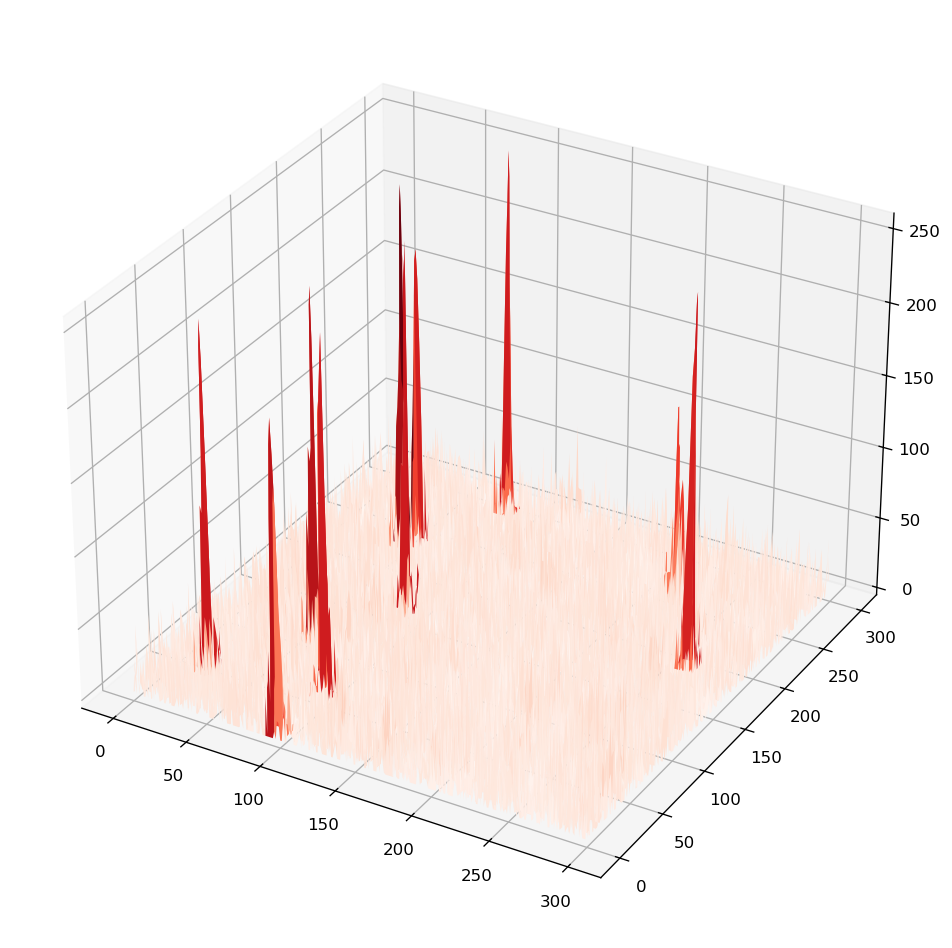

In [81]:
# 3D-Visualization (X,Y, intensity)
fig = plt.figure(dpi=120)
ax1 = np.arange(0,img_with_spots.shape[1],1)
xx, yy = np.meshgrid(ax1, ax1)
ax_3D = plt.axes(projection='3d')
ax_3D.plot_surface(xx, yy, img_with_spots[0,:,:,0], cmap='Reds')
plt.show()

# 2. Particle Tracking Process

![alt text](FigsA/Module_1_3/Slide5.png)

## 2.A. Particle detection

### Binarization

In [ ]:
threshold = 100  # Values in range [0, 255]

In [ ]:
# Define an intensity treshold
selected_time_point = 1
img_tracking = img_with_spots.copy() # copy of the image.
slected_tp_img = img_tracking[selected_time_point,:,:,0] # selecting a time point

## Image binarization
# Making spots above the threshold equal to 255. The maximum value in a 8-bit image.
slected_tp_img[slected_tp_img>threshold] = 255
# Making spots below the treshold equal to 0.
slected_tp_img[slected_tp_img<threshold] = 0
# Binarization
slected_tp_img[slected_tp_img!=0] = 1

In [ ]:
# Plotting
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(img_with_spots[selected_time_point,:,:,0],cmap='Greens_r')
ax[0].set_title('Simulated spots')
ax[1].imshow(slected_tp_img,cmap='Greys_r')
ax[1].set_title('Binary image with pixels above treshold')
plt.show()

In [ ]:
# Joining pixels in "particles"
contours = measure.find_contours(slected_tp_img, 0.5)
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(slected_tp_img, cmap=plt.cm.gray)
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

### Detecting particles (center of mass) for all frames

In [ ]:
# Function for a particle detector
def particle_detector(img,threshold):
  '''
  This function is intended to detect spots above a given threshold.
  Inputs:
    img: numpy array with dimenssions [T,Y,X,C]
    threshold: float.

  Returns
    list_all_time_point_center_mass: list of centers of mass for each time point.  [ [ cm_particle_0_tp_0, ..., cm_particle_n_tp_0], ... , [ cm_particle_0_tp_n, ..., cm_particle_n_tp_n] ]
  '''
  img_tracking = img.copy() # copy of the image.
  num_time_points = img_tracking.shape[0]
  list_all_time_point_center_mass  =[]
  
  # Loop through all time points
  for i in range (num_time_points):
    
    list_center_mass = []
    slected_tp_img = img_tracking[i,:,:,0] # selecting a time point
    
    # Making spots above the threshold equal to 255.
    slected_tp_img[slected_tp_img>threshold] = 255
    
    # Making spots below the threshold equal to 0.
    slected_tp_img[slected_tp_img<threshold] = 0
    
    # Binarization
    slected_tp_img[slected_tp_img!=0] = 1
    
    # Joining pixels and deffining particles
    contours = measure.find_contours(slected_tp_img)
    
    # Calculating the center of each particle
    for contour in contours:
      center_mass = np.mean(contour, axis = 0)
      list_center_mass.append(center_mass)
    
    # Saving results as a list of centers of mass for each time point.  [ [ cm_particle_0_tp_0, ..., cm_particle_n_tp_0], ... , [ cm_particle_0_tp_n, ..., cm_particle_n_tp_n] ]
    list_all_time_point_center_mass.append(list_center_mass)
  
  return list_all_time_point_center_mass

In [ ]:
list_all_time_point_center_mass = particle_detector(img_with_spots,threshold=100)

In [ ]:
# List containing [Y,X] positions for the center of mass for each particle.
list_all_time_point_center_mass[1] # Selecting a time point

In [ ]:
# Plotting center of mass of each particle
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img_with_spots[selected_time_point,:,:,0], cmap=plt.cm.gray)
for i in range(0,len(list_all_time_point_center_mass[selected_time_point])):
  ax.plot(list_all_time_point_center_mass[selected_time_point][i][1], list_all_time_point_center_mass[selected_time_point][i][0], color='r',marker='*')
plt.show()

## 2.B. Linking trajectories

In [ ]:
#@title Function to link spots

def linking_spots(list_center_mass):
  '''
  This function is intended to link trajectories given a list of centers of mass.
  Inputs:
    list_center_mass: list of centers of mass for each time point.  [ [ cm_particle_0_tp_0, ..., cm_particle_n_tp_0], ... , [ cm_particle_0_tp_n, ..., cm_particle_n_tp_n] ]

  Returns
    list_trajectories: list of connected coordinates for all particles and all time points.
    [
    [ [Y_val_particle_0_tp_0, X_val_particle_0_tp_0]   , ... , [Y_val_particle_n_tp_0, X_val_particle_n_tp_0] ]
    ...
    [ [Y_val_particle_0_tp_n, X_val_particle_0_tp_n]   , ... , [Y_val_particle_n_tp_n, X_val_particle_n_tp_n] ]
    ]
  '''
  def get_points_on_frame(i):
      # Sub-function to convert each  element  in the list into a numpy array
      return np.array(list_center_mass[i])

  # Look for the nearest point slice by slice:
  number_frames = len (list_center_mass)
  start_positions = np.array(list_center_mass[0])

  ###### STEP 1 #########
  # FOR EVERY FRAME WE DETECTED THE PARTICLES IN THE SYSTEM
  # WE GIVE AN INDEX TO EACH PARTICLE IN EVERY FRAME
  # ARRAY ROW = FRAME COL = PARTICLE_INDEX
  idx_nearest_trajectories = np.arange(start_positions.shape[0]).reshape(1, -1) # 1D vector with the size of the number of particles
  # Loop for all frames
  for i in range(1, number_frames):
      # This class provides an index into a set of k-dimensional points which can be used to rapidly look up the nearest neighbors of any point.
      # help(KDTree)
      # help(KDTree.query)
      get_nearest = KDTree(get_points_on_frame(i))
      previous_points = get_points_on_frame(i-1)[idx_nearest_trajectories[-1, :]]
      # Returns the distances and index to the nearest neighbors.
      distance, idx_nearest = get_nearest.query(previous_points)
      # concatenate the idx_nearest_trajectories for every frame
      idx_nearest_trajectories = np.vstack((idx_nearest_trajectories, idx_nearest))
  #print('List of particle_index vs frame  \n', idx_nearest_trajectories)

  ###### STEP 2 #########
  # Converting array with particle_indexes to coordinates
  # indexing the list_center_mass using idx_nearest_trajectories
  list_trajectories =[]
  for path_idx in idx_nearest_trajectories.T:
    path_coords = [list_center_mass[i][idx] for i, idx in enumerate(path_idx)]
    list_trajectories.append(path_coords)
  return list_trajectories

In [ ]:
# Linking the center of mass for each particle in all frames
list_trajectories_short = linking_spots (list_all_time_point_center_mass)

In [ ]:
list_trajectories_short[1]  # particle trajectory

In [ ]:
# Plotting the trajectory for the first particle in the system
plt.plot(list_trajectories_short[0][0][0], list_trajectories_short[0][0][1]  , 'ko', markersize=10) # stating position    [particle][Frame][X],[particle][Frame][Y]
plt.plot(*zip(*list_trajectories_short[0]), '-r', linewidth=2)
plt.plot(list_trajectories_short[0][-1][0], list_trajectories_short[0][-1][1]  , 'k*', markersize=10) # ending position    [particle][Frame][X],[particle][Frame][Y]
plt.show()

What is the [Star Operator](https://www.tutorialspoint.com/What-does-the-Star-operator-mean-in-Python) doing in the previous block of code?

The star operator is used to unpack the values of a list or tuple. In the context of the code, it is used to unpack the values of the `x` and `y` coordinates of the detected particles in the `link_particles` function.

In [ ]:
# Plotting individual trajectories history.
plt.figure(figsize=(6, 6))
for i in range(0, len(list_trajectories_short)):
    plt.plot(*zip(*list_trajectories_short[i]), '-', linewidth=2)
plt.xlim([0, img_size[1]])
plt.ylim([img_size[0], 0])   # Notice that we are reversing the order in the Y-axis
plt.show()

In [ ]:
# Make a movie of the original, but now add squares over the tracked particles.

# Plotting spots as a video

fig, ax = plt.subplots(figsize=(7,7))

def movieFrame(i):
  ax.clear()
  ax.imshow(img_with_spots[i,:,:,0],cmap= 'gray')

  for iParticle in range(len(list_trajectories_short)):
      x_val = [x[1] for x in list_trajectories_short[iParticle][:i]]
      y_val = [x[0] for x in list_trajectories_short[iParticle][:i]]
      if len(x_val)>=1:
        # Add a circle over the detected spot
        ax.plot(x_val[-1],y_val[-1], 'o', linewidth = 1, markersize=8, color='y', alpha=0.25)
        
        # Add a line to show the trajectory of the spot.
        ax.plot(x_val,y_val, linewidth = 2, alpha=0.75)

  return [fig]

plt.close()
anim = animation.FuncAnimation(fig, movieFrame, frames=img_with_spots.shape[0], interval=50, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# 3. Calculating the Mean Square Displacement (MSD)

MSD is a metric to calculate the average movement of particles with respect to time. [MSD formal definition](https://en.wikipedia.org/wiki/Mean_squared_displacement).

${\rm MSD}=\frac{1}{N}\sum_{i=1}^N |\mathbf{x^{(i)}}(t) - \mathbf{x^{(i)}}(0)|^2 $

where $N$ is the number of particles, $\mathbf{x^{(i)}}(0)$ is the reference position of the $i^{th}$ particle, and $\mathbf{x^{(i)}}(t)$ is the position of the $i^{th}$ particle at time $t$.

## 3.A. Different types of diffusive motion

In a random Browinian motion, there is a linear relationship between the MSD and time $t$. [Link with the derivation of this formula](https://en.wikipedia.org/wiki/Mean_squared_displacement).

$MSD= 2nDt$,

where $n$ is the number of dimensions,  $D$ is the  diffusion coefficient,

$D= \frac{k_B \cdot T}{6 \pi \eta r}$ (Einstein-Stokes equation)

*   Proportional to: $k_B$ Boltzman constant, $T$ absolute temperature
*   Inversely Proportional: $\eta$ is the viscocity, $r$ particle radius.


![alt text](FigsA/Module_1_3/Slide6.png)

Addtional [image](https://en.wikipedia.org/wiki/Anomalous_diffusion#/media/File:Msd_anomalous_diffusion.svg) with anomalous diffusion.

In [ ]:
# Function to calculate msd
def compute_msd(trajectory):
  '''
  This function is intended to calculate the mean square displacement of a given trajectory.
  msd(τ)  = <[r(t+τ) - r(t)]^2>
  Inputs:
    trajectory: list of temporal evolution of a centers of mass .  [Y_val_particle_i_tp_0, X_val_particle_i_tp_0]   , ... , [Y_val_particle_i_tp_n, X_val_particle_i_tp_n] ]

  Returns
    msd: float, mean square displacement
    rmsd: float, root mean square displacement
  '''
  total_length_trajectory=len(trajectory)
  msd=[]
  for i in range(total_length_trajectory-1):
      tau=i+1
      # Distance that a particle moves for each time point (tau) divided by time
      # msd(τ)                 = <[r(t+τ)  -    r(t)]^2>
      msd.append(np.sum((trajectory[0:-tau]-trajectory[tau::])**2)/float(total_length_trajectory-tau)) # Reverse Indexing
  # Converting list to np.array
  msd=np.array(msd)   # array with shape Nspots vs time_points
  rmsd = np.sqrt(msd)
  return msd, rmsd

Useful links to implement msd [link with code implementation](https://stackoverflow.com/questions/53443486/calculating-mean-square-displacement-for-a-single-particle-in-1d)  and [paper](https://web.mit.edu/savin/Public/.Tutorial_v1.2/Introduction.html).

In [ ]:
# Running the 2D random walk simulator
img_size_kd =[1000, 1000]
num_time_points = 40
diffusion_coeffient = 0.5
percentage_background_noise = 0
number_spots = 200
img_with_spots_kd = brownian_movement_simulator(img_size =img_size_kd,num_time_points=num_time_points, number_spots=number_spots, diffusion_coeffient =diffusion_coeffient, percentage_background_noise= percentage_background_noise)

In [ ]:
# Detecting particles
list_center_mass_kd = particle_detector(img_with_spots_kd,threshold=180)

# Linking trajectories
list_trajectories_kd = linking_spots (list_center_mass_kd)
num_trajectories = len(list_trajectories_kd)

In [ ]:
# Calculating the MSD
t=np.arange(1,num_time_points,1)
msd_trajectories = np.zeros((num_trajectories,num_time_points-1))
rmsd_trajectories = np.zeros((num_trajectories,num_time_points-1))
for i in range(0,num_trajectories):
  msd_trajectories[i,:], rmsd_trajectories[i,:] = compute_msd(np.array(list_trajectories_kd[i]))

In [ ]:
list_trajectories_kd[0][0]

In [ ]:
# Plotting the MSD for every particle in  the simulation
for i in range(0,num_trajectories):
  plt.plot(msd_trajectories[i,:],'-',color=[0.5,0.5,0.5])
plt.show()

In [ ]:
# MSD Statistics (mu, sigma) for all trajectories.
msd_trajectories_all_mu = np.mean(msd_trajectories,axis=0)
msd_trajectories_all_sem = np.std(msd_trajectories,axis=0) /np.sqrt(num_trajectories)

In [ ]:
# MSD calculated from fromula
n_dimens = 2
msd_formula = 2*n_dimens*diffusion_coeffient*t

In [ ]:
# Plotting the MSD vs Time
downsampling = 3
plt.figure(figsize=(7, 5))
for i in range(0,num_trajectories):
  plt.plot(msd_trajectories[i,:],'-',color=[0.8,0.8,0.8])
plt.errorbar(t[::downsampling], msd_trajectories_all_mu[::downsampling],  yerr=msd_trajectories_all_sem[::downsampling],ecolor='blue',linestyle='')
plt.plot(t[::downsampling], msd_trajectories_all_mu[::downsampling], marker='o', markersize=12, linestyle='none',color='blue',label ='simulation' )
plt.plot(t, msd_formula, color='red', linewidth=4,label ='msd_formula 2nDt')
plt.legend()
plt.title('Mean square displacement')
plt.ylabel('MSD (au)')
plt.xlabel('Time (au)')
plt.ylim(0,150)
plt.show()

### In the following widget move the slider bar to increase/decrease the value of the Diffusion coefficient (D) in the simulation. 

Discuss why the apparrent value for the diffusion constant is innaccurate when the rate is too fast or too small.

In [ ]:
# Plotting the msd as function of time for multiple $D$

plt.rcParams["figure.figsize"] = (5,5) # if movie is too big, change size to (7,7)

def figure_viewer(log10_diffusion_coeffient=0):
    # Running the 2D random walk simulator
    img_size_kd =[1000, 1000]
    num_time_points = 100
    percentage_background_noise = 0
    number_spots = 100

    diffusion_coeffient = 10**log10_diffusion_coeffient
    
    # Generating images
    img_with_spots_kd = brownian_movement_simulator(img_size =img_size_kd,num_time_points=num_time_points, number_spots=number_spots, diffusion_coeffient =diffusion_coeffient, percentage_background_noise= percentage_background_noise)
    
    # Detecting particles
    list_center_mass_kd = particle_detector(img_with_spots_kd,threshold=180)
    
    # Linking trajectories
    list_trajectories_kd = linking_spots (list_center_mass_kd)
    num_trajectories = len(list_trajectories_kd)
    
    # Calculating the MSD
    t=np.arange(1,num_time_points,1)
    msd_trajectories = np.zeros((num_trajectories,num_time_points-1))
    rmsd_trajectories = np.zeros((num_trajectories,num_time_points-1))
    for i in range(0,num_trajectories):
      msd_trajectories[i,:], rmsd_trajectories[i,:] = compute_msd(np.array(list_trajectories_kd[i]))
    
    # MSD Statistics (mu, sigma) for all trajectories.
    msd_trajectories_all_mu = np.mean(msd_trajectories,axis=0)
    msd_trajectories_all_sem = np.std(msd_trajectories,axis=0) /np.sqrt(num_trajectories)
    
    # MSD calculated from fromula
    msd_formula = 2*n_dimens*diffusion_coeffient*t
    
    # Plotting the MSD vs Time
    down_sampling = 3
    plt.errorbar(t[::down_sampling], msd_trajectories_all_mu[::down_sampling],  yerr=msd_trajectories_all_sem[::down_sampling],ecolor='grey',linestyle='')
    plt.plot(t[::down_sampling], msd_trajectories_all_mu[::down_sampling], marker='o', markersize=12, linestyle='none',color='grey',label ='simulation' )
    plt.plot(t, msd_formula, color='red', linewidth=4,label ='msd_formula')
    plt.legend()
    plt.title('Mean square displacement')
    plt.ylabel('MSD (au)')
    plt.xlabel('Time (au)')
    plt.show()

interactive_plot = interactive(figure_viewer,log10_diffusion_coeffient = widgets.FloatSlider(min=-3,max=3,step=0.25,value=0,description='log10(D)'),continuous_update=False)
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]
display(VBox([controls, output]))

## 3.B. Visualizing movement for Brownian and non-Browinian motion

In [ ]:
# Running the 2D random walk simulator
img_size =[400, 400]
num_time_points = 50
diffusion_coeffient = 0.0001
number_spots = 10
percentage_background_noise = 0.01
img_with_spots = brownian_movement_simulator(img_size =img_size,num_time_points=num_time_points, number_spots=number_spots, diffusion_coeffient =diffusion_coeffient, percentage_background_noise= percentage_background_noise)

In [ ]:
# Particle movement video
# Plotting spots as a video
fig = plt.figure(figsize=(7,7))
#Define inital frames
im = plt.imshow(img_with_spots[0,:,:,0],cmap= 'Reds_r') # Reds_r
#plt.axis('off')
def movieFrame(i):
  images = [img_with_spots[i,:,:,0]]
  image_handles = [im]
  for k, image_n in enumerate(images):
    image_handles[k].set_array(images[k])
  return image_handles
plt.close()
anim = animation.FuncAnimation(fig, movieFrame, frames=img_with_spots.shape[0], interval=50, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

# 4. More complex scenarios

![alt text](FigsA/Module_1_3/Slide7.png)

## 4.A. Running a simulation with Background noise.
In real life scenarios, the images of particles are affected by background noise. In this section, we will add a background noise to the simulation.

In [ ]:
# Running the 2D random walk simulator
img_size_ns =[100, 100]
num_time_points = 10
diffusion_coeffient = 0.5
percentage_background_noise = 0.2   ### adding 20% BG noise
number_spots = 30
img_with_spots_noisy = brownian_movement_simulator(img_size =img_size_ns,num_time_points=num_time_points, number_spots=number_spots, diffusion_coeffient =diffusion_coeffient, percentage_background_noise= percentage_background_noise)

In [ ]:
# Running the particle detector using a noisy image
list_center_mass = particle_detector(img_with_spots_noisy,threshold=250)  # Test different values for the threshold

In [ ]:
# Plotting
selected_time_point =0
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(img_with_spots_noisy[selected_time_point,:,:,0], cmap=plt.cm.gray, alpha=0.5)
ax[0].set_title('Simulated spots')
ax[1].imshow(img_with_spots_noisy[selected_time_point,:,:,0], cmap=plt.cm.gray, alpha=0.5)
for i in range(0,len(list_center_mass[selected_time_point])):
  ax[1].plot(list_center_mass[selected_time_point][i][0], list_center_mass[selected_time_point][i][1], color='r',marker='*')
ax[1].set_title('Binary image with pixels above treshold')
plt.show()

### Reducing the noise in the image by using filters.

In [ ]:
# Using a filter to remove noise
from scipy.ndimage import gaussian_filter
from skimage.filters import difference_of_gaussians

# img_with_spots_gaussian_filter = img_with_spots_noisy.copy() # making a copy of our img

# Applying a Gaussian filter
# img_with_spots_filter = gaussian_filter(img_with_spots_gaussian_filter, sigma=2)

# Applying a Differences of Gaussians Filter
img_with_spots_filter = difference_of_gaussians(img_with_spots_noisy, low_sigma=2, high_sigma=4)

In [ ]:
# Make pair of figures. the first is the filtered image, and the second is a histogram of the pixel values.
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(img_with_spots_filter[selected_time_point,:,:,0], cmap=plt.cm.gray)
ax[0].set_title('Filtered image')
ax[1].hist(img_with_spots_filter[selected_time_point,:,:,0].flatten(), bins=100, color='k')
ax[1].set_title('Histogram of pixel values')
plt.show()



In [ ]:
# Running the particle detector using the image after applying the filter
# list_center_mass_removed_noise = particle_detector(img_with_spots_filter,threshold=100)
list_center_mass_removed_noise = particle_detector(img_with_spots_filter,threshold=0.18)

In [ ]:
# Plotting
selected_time_point =0
fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(img_with_spots_filter[selected_time_point,:,:,0], cmap=plt.cm.gray)
ax[0].set_title('Simulated spots')
ax[1].imshow(img_with_spots_filter[selected_time_point,:,:,0], cmap=plt.cm.gray)
for i in range(0,len(list_center_mass_removed_noise[selected_time_point])):
  ax[1].plot(list_center_mass_removed_noise[selected_time_point][i][1], list_center_mass_removed_noise[selected_time_point][i][0], color='r',marker='*')
ax[1].set_title('Binary image with pixels above treshold')
plt.show()

## 4.B. Example: Ribosomal frameshifting. Two mRNAs interact for some seconds.

In [ ]:
HTML("""<video width="560" alt="test" controls> <source src="https://github.com/MunskyGroup/uqbio2021/raw/main/module_1/tracking/bursting.mp4" type="video/mp4"></video>""")

# 5. Using Libraries for Particle Tracking

![alt text](FigsA/Module_1_3/Slide9.png)

![alt text](FigsA/Module_1_3/Slide8.png)

![alt text](FigsA/Module_1_3/Slide10.png)

## Dowloading data

In [ ]:
# Downloading data
urls = ['https://github.com/MunskyGroup/uqbio2021/raw/main/module_1/images/simulated_cell.tif'] # loading simulated data
print('Downloading file...')
urllib.request.urlretrieve(urls[0], './simulated_cell.tif')

In [ ]:
# Importing the video as a numpy array
figName = './simulated_cell.tif'
video = imread(figName)  #Numpy array [T,Y,X,C]
# dimensions in the video
number_timepoints, y_dim, x_dim, number_channels = video.shape[0], video.shape[1], video.shape[2], video.shape[3] # obtaining the dimensions size
print(video.shape)

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(video[0,:,:,1],cmap='gray')
plt.show()

In [ ]:
# Imoporting the library with the filter modules
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import img_as_float
from skimage.filters import difference_of_gaussians

img_copy = video.copy() # making a copy of our img
img_section = img_copy[0,:,:,1] # selecting a timepoint and color channel

img2 = img_as_float(img_section)

# Applying the filter
img_gaussian_filter_simga_1 = difference_of_gaussians(img_section, 0.2, 50)
img_gaussian_filter_simga_10 = gaussian_filter(img_section, sigma=10)
sigma_est=0.0001
im_wavelet = denoise_wavelet(img2, rescale_sigma=True,method='BayesShrink', mode='soft', sigma = sigma_est)  #

sigma_est = estimate_sigma(im_wavelet, average_sigmas=True)

# Side-by-side comparizon
fig, ax = plt.subplots(1,3, figsize=(30, 10))
ax[0].imshow(img_section,cmap='gray')
ax[0].set(title='Original')

# noise reduction
ax[1].imshow(img_gaussian_filter_simga_1,cmap='gray')
ax[1].set(title='Gaussian Filter $\sigma$ =1 Noise reduction')

# Blurring
ax[2].imshow(im_wavelet,cmap='gray')
ax[2].set(title='denoise_wavelet')
plt.show()

In [ ]:
# Plotting Video
from matplotlib import animation
from IPython.display import HTML
def make_movie(image_tensor, cmaps = ['Reds_r','Greens_r','Blues_r'], channels = True):
  '''
  returns an ipython.html obj to display an image tensor
  '''
  if channels:  # if channels = True we will make a 3 color / 3 plot movie
    fig,axes = plt.subplots(1,2,figsize=(20,7),tight_layout=True,)
  else: # otherwise just one subplot is needed
    fig,axes = plt.subplots(1,1,figsize=(20,7),tight_layout=True,) #tight layout sets the axis's apart
  #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  if channels: #if channels set up inital images here
    im1 = axes[0].imshow(image_tensor[0,:,:,0], cmap=cmaps[0])  #get blank axes.image objects to maniuplate later
    im2 = axes[1].imshow(image_tensor[0,:,:,1], cmap=cmaps[1])
    #im3 = axes[2].imshow(image_tensor[0,:,:,2], cmap=cmaps[2])
    for k in range(2):
      axes[k].set_title('Channel %i'%k)
  else:
    im1 = axes.imshow(image_tensor[0,:,:,:], cmap=cmaps[0]) #if merge just make one
    axes.set_title('Merge')
  plt.close()

  #here set up the function that is called by FuncAnimation, it returns the artist objects and updates the frame by i
  def movieFrame(i):
    ## Extract all the image channels
    #Define  frames
    if channels:  #get the channels if 3 color
      channel_1_img = image_tensor[i,:,:,0]
      channel_2_img = image_tensor[i,:,:,1]
      #channel_3_img = image_tensor[i,:,:,2]
      images = [channel_1_img, channel_2_img]  # concatenate channels
      axes_handles = [im1,im2]  #Axes handles from the imshow
    else:
      channel_img = image_tensor[i,:,:,:]
      images = [channel_img,]  # concatenate channels
      axes_handles = [im1,]  #Axes handles from the imshow

    #update the axes imshow objects with the new data per k channels
    for k,image_n in enumerate(images):  #for loop that returns an object and an index
      axes_handles[k].set_array(images[k])  #
    return axes_handles  #return the object

  #here call the animation function from matplotlib and then return the final HTML video object to the user
  anim = animation.FuncAnimation(fig, movieFrame, frames=image_tensor.shape[0], interval=100, blit=True)
  return HTML(anim.to_html5_video())

In [ ]:
make_movie(video)

## Cell segmentation

In [ ]:
# RUN CELLPOSE
imgs_2D = video[0,:,:,0] # [T,Y,X,C]
use_GPU = False
# DEFINE CELLPOSE MODEL
model = models.Cellpose(gpu=use_GPU, model_type='cyto') # model_type='cyto' or model_type='nuclei'

# Running the models
masks, flows, styles, diams = model.eval(imgs_2D, diameter=200, flow_threshold=None, channels=[0,0])

In [ ]:
num_masks = np.amax(masks)
if num_masks >1:
  masks_nuc_area = [np.count_nonzero(masks==j) for j in range(1, num_masks+1)]
  largest_mask = np.argmax(masks_nuc_area) +1
  selected_masks =  np.where(masks == largest_mask, 1, 0)

In [ ]:
plt.imshow(masks)

In [ ]:
plt.imshow(selected_masks)

## Particle tracking using Trackpy

In [ ]:
# Plotting just the masked image.
plt.figure(figsize=(5,5))
plt.imshow(video[0,:,:,0]*selected_masks,cmap='gray')
plt.show()

The particle tracking is performed using [trackpy](http://http://soft-matter.github.io/trackpy/v0.5.0/)
The library documentation can be accessed in the following [link](https://buildmedia.readthedocs.org/media/pdf/trackpy/v0.2.3/trackpy.pdf).

## Manual selection. (Initial step)

### Visualizing the distribution for the particles' intensity


In [ ]:
# This section generates an histogram with the intensity of the detected particles in the video.

particle_size = 7 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.

# "f" is a pandas data freame that contains the infomation about the detected spots
f = tp.locate(video[10,:,:,0], particle_size, minmass=minimal_intensity_for_selection)

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count');
ax.set_ylim([0,200])
plt.show()

In [ ]:
help(tp.locate)

### Select an intensity threshold value and particle size

In the following widget, the user is asked to manually input the particle size and the Intensity threshold, these numbers will be used for during the rest of the code to calculate intensities. Notice that tracking is only performed on channel 0.

In [ ]:
# To start visualization move the time slider.
plt.rcParams["figure.figsize"] = (10,10) # if movie is too big, change size to (7,7)
def figure_viewer_tr(time,mass_text, drop_size):
    ch = 0
    f = tp.locate(video[time,:,:,ch],drop_size, minmass=mass_text,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
    tp.annotate(f,video[time,:,:,ch]);  # tp.anotate is a trackpy function that displays the image with the detected spots

values_size=[3,5,7,9] # Notice value must be an odd number.
interactive_plot_tr = interactive(figure_viewer_tr,mass_text = widgets.IntText(value=500,min=10,description='min Intensity'),drop_size = widgets.Dropdown(options=values_size,value=7,description='Particle Size'),time = widgets.IntSlider(min=0,max=video.shape[0]-1,step=1,value=0,description='Time'))
controls = HBox(interactive_plot_tr.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot_tr.children[-1]
display(VBox([controls, output]))

### Saving the threshold parameters that will be used to define the spot selection criteria

In [ ]:
# This section saves the parameters adjusted in the previous widget in two variables that will be use for the rest of the code.
selected_intensity = interactive_plot_tr.kwargs_widgets[1].value
selected_size = interactive_plot_tr.kwargs_widgets[2].value

### Detecting the spots in all frames

In [ ]:
# Loop through each frame of the video, run TP to detect spots, and then create a single
# data frame for all time points.
ch = 0
df_TrackPy = tp.locate(video[0,:,:,ch],selected_size, minmass=selected_intensity,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
df_TrackPy['frame'] = 0

for iFrame in range(1,video.shape[0]):
    f = tp.locate(video[iFrame,:,:,ch],selected_size, minmass=selected_intensity,maxsize=7,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots
    f['frame'] = iFrame
    df_TrackPy = pd.concat([df_TrackPy,f])

df_TrackPy

### Removing particles outside the mask

In [ ]:
# Create a function that extracts the y and x coordinates from the dataframe and
# return an exteneded data frame that includes a boolean true if the spot is in 
# the mask and false otherwise.
def spots_in_mask(f,mask):
    # extracting the contours in the image
    coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
    f['In Mask']=values_at_coords # Check if pts are on/in polygon mask
    return f

In [ ]:
# Remove spots that are not contained in the cell masks
df_masked = spots_in_mask(df_TrackPy,selected_masks)
dataframe_particles_in_mask = df_masked[df_masked['In Mask']==True]
dataframe_particles_in_mask

### Linking all detected spots accross all frames

---



In [ ]:
# tp.link_df is a trackpy function that links spots detected in multiple frames, this generates the spots trajectories in time.
df_linked_particles = tp.link_df(dataframe_particles_in_mask,5, memory=2) # tp.link_df(data_frame, max_distance_particle_moves, max_time_particle_vanishes).

### Eliminating spurious trajectories.

In [ ]:
#trackpy.filtering.filter_stubs(tracks, threshold=100)
df_linked_particles_filtered = tp.filter_stubs(df_linked_particles, 10)  # selecting trajectories that appear in at least 10 frames.
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', df_linked_particles['particle'].nunique())
print('After:', df_linked_particles_filtered['particle'].nunique())

### Storing particle trajectories in a Pandas data frame

[Pandas data Library ](https://pandas.pydata.org) and a [link](https://pandas.pydata.org/docs/user_guide/10min.html) with a 10min guide to learn pandas.

### Extracting information from a Pandas data frame using conditional indexing

In [ ]:
# Pandas data frame
df_linked_particles_filtered


In [ ]:
# For simplicity, I  will create a new df with a short name
dfp =  df_linked_particles_filtered

In [ ]:
# Showing information for a selected_particle
selected_particle = 3
dfp.loc[dfp['particle']==selected_particle ]

In [ ]:
# Showing information for a selected_frame
selected_frame = 0
dfp.loc[dfp['frame']==selected_frame]

In [ ]:
# Extracting the intensity values for selected_particle
selected_particle = 3
dfp.loc[dfp['particle']==selected_particle].mass.values

In [ ]:
# Extracting the intensity values for particles with intensity higher than a threshold and in frame 0
dfp.loc[(dfp['mass']>=2000) & (dfp['frame']==0)  ]

### Exporting tracks to CSV.

In [ ]:
# Optional section that saves the particles trajectories and intensities as a CSV file
dfp.to_csv(r'tracking_particles.csv', index = False)

#Plotting trajectories in x-y.

In [ ]:
# Plotting
plt.figure(figsize=(10,10))
for i in range(0,dfp['particle'].nunique() ):
  x_val = dfp.loc[dfp['particle']==i ].x.values[:]
  y_val = dfp.loc[dfp['particle']==i ].y.values[:]
  plt.plot(x_val,y_val, '-',linewidth = 3 )
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Particle movement 2D')
plt.show()

In [ ]:
# Make a movie of the original, but now add squares over the tracked particles.

# Plotting spots as a video

fig, ax = plt.subplots(figsize=(7,7))

def movieFrame(i):
  ax.clear()
  ax.imshow(video[i,:,:,0],cmap= 'gray')

  for iParticle in range(0,dfp['particle'].nunique() ):
      x_val = dfp.loc[(dfp['particle']==iParticle) & (dfp['frame']<=i) ].x.values
      y_val = dfp.loc[(dfp['particle']==iParticle) & (dfp['frame']<=i) ].y.values
      if len(x_val)>=1:
        # Add a circle over the detected spot
        ax.plot(x_val[-1],y_val[-1], 'o', linewidth = 1, markersize=8, color='y', alpha=0.25)
        
        # Add a line to show the trajectory of the spot.
        ax.plot(x_val,y_val, linewidth = 2, alpha=0.75)

  return [fig]

plt.close()
anim = animation.FuncAnimation(fig, movieFrame, frames=video.shape[0], interval=50, blit=True)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
# Make a movie of the original, but now add squares over the tracked particles.
# Also, now we add a zoom in to show the behavior of a single particle over time.

def movieViewer(spot_number = 0):
  fig, ax = plt.subplots(1,2, figsize=(14,7))
  def movieFrame(i):
    ax[0].clear(); ax[1].clear()
    x_val = dfp.loc[(dfp['particle']==spot_number) & (dfp['frame']==i) ].x.values
    y_val = dfp.loc[(dfp['particle']==spot_number) & (dfp['frame']==i) ].y.values   
    
    ax[0].imshow(video[i,:,:,0],cmap= 'gray')
    ax[0].plot(x_val,y_val, 'o', linewidth = 1, markersize=8, color='y', alpha=0.25)

    if len(x_val)>0:    
      ylim = [int(x_val[0]-7), int(x_val[0]+8)]
      xlim = [int(y_val[0]-7), int(y_val[0]+8)]
      ax[1].imshow(video[i,xlim[0]:xlim[1],ylim[0]:ylim[1],1],cmap= 'Spectral_r')
    return [fig]

  plt.close()
  anim = animation.FuncAnimation(fig, movieFrame, frames=video.shape[0], interval=50, blit=True)
  return anim

anim = movieViewer(spot_number=3)
HTML(anim.to_html5_video())


# interactive_plot = interactive(movieViewer,spot_number = widgets.IntSlider(min=0,max=dfp['particle'].nunique(),value=0,description='Particle Number'),continuous_update=False)
# controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# output = interactive_plot.children[-1]
# display(VBox([controls, output]))


### Plotting trajectories versus intensity using trackpy

Notice that the particle number is not consecutive, for that reason the indexing is as follows:
dfp['particle'].unique()  

Where dfp.unique() is a method that return the number of unique values in the dfp.

In [ ]:
# Defining the number of detected spots.
n_particles = dfp['particle'].nunique()

# Plotting
plt.figure(figsize=(20,5))

# plotting intensities in au
for id in range(0,n_particles):
    plt.plot(dfp.loc[dfp['particle']==dfp['particle'].unique()[id]].frame, dfp.loc[dfp['particle']==dfp['particle'].unique()[id]].mass )
plt.xlabel('Time (sec)')
plt.ylabel('Intensity a.u.')
plt.title('Intensity vs Time')
plt.show()

# References

* Video source: Lyon, K., Aguilera, L.U., Morisaki, T., Munsky, B. and Stasevich, T.J., 2019. Live-cell single RNA imaging reveals bursts of translational frameshifting. Molecular cell, 75(1), pp.172-183. https://www.sciencedirect.com/science/article/pii/S1097276519303557

* Image source: MacKintosh, F.C., 2012. Active diffusion: the erratic dance of chromosomal loci. Proceedings of the National Academy of Sciences, 109(19), pp.7138-7139. https://www.pnas.org/content/109/19/7138

*   Code to generate a gaussian kernel matrix
https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy

*   Code to link coordenates
https://stackoverflow.com/questions/52129486/python-find-the-nearest-neighbor-pairs-in-a-list-of-point-coordinates

*   Code to compute mean square displacement
https://stackoverflow.com/questions/26472653/computing-the-mean-square-displacement-of-a-2d-random-walk-in-python

*   u-track (multiple-particle tracking)
https://www.utsouthwestern.edu/labs/jaqaman/software/

*  Wikipedia contributors, "Mean squared displacement," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Mean_squared_displacement&oldid=930410532 (accessed June 10, 2021).

* Stringer, C., Wang, T., Michaelos, M. and Pachitariu, M., 2021.Cellpose: a generalist algorithm for cellular segmentation. Nature Methods, 18(1), pp.100-106. https://github.com/MouseLand/cellpose

* Allan, Daniel B., Caswell, Thomas, Keim, Nathan C., van der Wel, Casper M., & Verweij, Ruben W. (2021, April 13). soft-matter/trackpy: Trackpy v0.5.0 (Version v0.5.0). Zenodo. http://doi.org/10.5281/zenodo.4682814